In [1]:
%load_ext autoreload
%autoreload 2

# https://www.ishares.com/us/products/239706/ishares-russell-1000-growth-etf
# https://aroussi.com/post/python-yahoo-finance
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import pandas as pd
import pickle
import scipy.stats as stats

# Download Yahoo Data (5 minute interval)

In [2]:
import YahooStocks

tix = "MSFT AAPL GOOG TSLA AMZN FB KIRK V MA UNH NFLX CRM NKE HD COST KO AMT LOW UPS ZM MMM"
# Initialize
stocks = YahooStocks.Stocks(tix)
# Download Yahoo and transform
stocks.get_data(interval = '30m')
stocks.transform_data()
# Write to transformed data to SQL
#stocks.insert_SQL()
# Read from SQL
#stocks.read_SQL('stockprice')

[*********************100%***********************]  21 of 21 completed


In [3]:
stocks.raw_data.shape

(65, 126)

In [4]:
stocks.transformed_data.to_csv('data/mydata.csv')

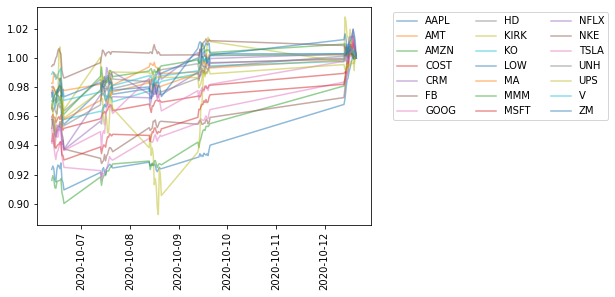

In [5]:
stocks.plot_raw(scale = -1)

# Model

In [6]:
stocks.transformed_data

,symbol,price
Datetime,,
2020-10-07 11:30:00-04:00,AAPL,114.681198
2020-10-08 11:30:00-04:00,AAPL,115.230003
2020-10-08 11:00:00-04:00,AAPL,115.445000
2020-10-08 10:30:00-04:00,AAPL,115.264999
2020-10-08 10:00:00-04:00,AAPL,115.209999
...,...,...
2020-10-08 14:30:00-04:00,ZM,482.429993
2020-10-08 14:00:00-04:00,ZM,481.739990
2020-10-08 13:30:00-04:00,ZM,481.089996


In [12]:
# Prepare Data
# Pivot so each stock time series is a column
data = stocks.transformed_data.pivot_table(columns = 'symbol', index = 'Datetime')['price']
# Note if pulling from SQL index = 'DateTime'
# Normalize by Last Value
data = data/data.iloc[-1]
data.index = pd.DatetimeIndex(data.index).to_period('M')

/home/erichullander/anaconda3/envs/StockPrice/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


# Out of Sample Validation (MASE)

https://robjhyndman.com/papers/forecast-accuracy.pdf
page 7. 

Using All data for each Q

In [13]:
def get_MASE(data,lags):
    # Calculate Q for each series. MAE of naive forecast for each series
    Q = np.abs(data.diff().dropna()).mean()
    # Calculate MASE for each series as 
    MASE = []
    MASEN = []
    n_ahead = 1
    # rolling origin point forecasts.
    # has to train on at least n = lags samples
    for n in range(lags,(data.shape[0] - 1)):
        try:
            M = YahooStocks.Model(data=data.iloc[0:n])
            M.fitVAR(lags)
            M.forecast(n_ahead)
            MAEnaive = np.abs(M.data.diff()).dropna().iloc[-1].values
            MAE = np.abs((data.iloc[n].values - M.fcast.values))[0]
            MASE.append(MAE/Q)
            MASEN.append(MAEnaive/Q)
        except:
            continue
    return MASE, MASEN

In [14]:
data.shape

(65, 21)

In [15]:
lags = 50
MASE, MASEN = get_MASE(data, 50)

# Significance Testing

In [16]:
# Across All Stocks, how does VAR compare to Naive?
# Not much different
A = pd.DataFrame(MASE).melt()['value']
B = pd.DataFrame(MASEN).melt()['value']
print(np.mean(A))
print(np.mean(B))
stats.ttest_rel(A, B)

1.003737691223694
1.111358467675828


Ttest_relResult(statistic=-1.262105900041002, pvalue=0.20818898935262842)

In [17]:
#just to remind myself...
#stats.ttest_1samp(A - B, 0)
stats.ttest_ind(pd.DataFrame(MASE)['AAPL'], pd.DataFrame(MASEN)['AAPL'])

Ttest_indResult(statistic=-0.9611328177120676, pvalue=0.34796236996248786)

In [18]:
# pairwise ttest between naive and var. Nobody looks significant, e.g. aapl naive to aapl var for all stocks
F, p = stats.f_oneway(np.array(MASE), np.array(MASEN), axis = 0)
p

array([0.34796237, 0.39380721, 0.45988321, 0.783063  , 0.73487301,
       0.79699063, 0.45718733, 0.84608324, 0.83493562, 0.92034112,
       0.6152528 , 0.81331565, 0.98552561, 0.61520816, 0.60318693,
       0.84558924, 0.42484153, 0.55967651, 0.91576239, 0.43426155,
       0.69450784])

In [19]:
A = pd.DataFrame(MASE).mean().values
B = pd.DataFrame(MASEN).mean().values

In [20]:
stats.ttest_ind(A, B)

Ttest_indResult(statistic=-0.9328532108639608, pvalue=0.35649276806691377)

In [21]:
F, p = stats.f_oneway(A, B, axis = 0)
p

0.35649276806691454

In [22]:
# Are there any stocks that are more predictable than others? Not really.
stats.f_oneway(*np.array(pd.DataFrame(MASE) - pd.DataFrame(MASEN)).T, axis = 0)

F_onewayResult(statistic=0.34410511309862307, pvalue=0.9964879191390494)

-0.1076207764521339


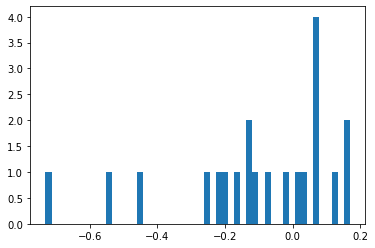

In [23]:
plt.hist(A - B, bins = 50)
print(np.mean(A - B))
plt.show()

# Forecast

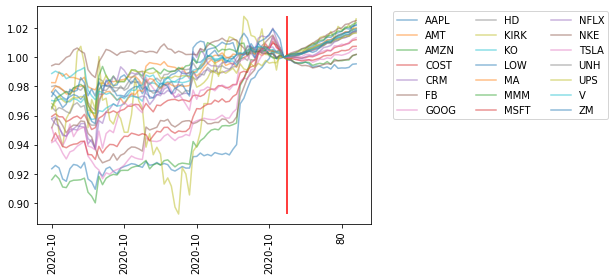

In [24]:
M = YahooStocks.Model(data=data)
M.fitVAR(lags)
M.forecast(20)
M.plot_fcast()

In [25]:
M.fcast.iloc[0].sort_values(ascending = False)

symbol
NKE     1.001703
UPS     1.001142
MMM     1.001139
ZM      1.000953
MA      1.000952
V       1.000792
LOW     1.000681
HD      1.000648
AMT     1.000615
CRM     1.000526
UNH     1.000497
COST    1.000405
KO      1.000389
NFLX    1.000298
TSLA    0.999908
MSFT    0.999698
GOOG    0.999580
FB      0.998844
AMZN    0.998799
KIRK    0.998570
AAPL    0.998140
Name: 65, dtype: float64